# Energy & Development Database - Data Visualization

*Author: Leilanie Rubinstein*

## Introduction

This notebook queries the `africa_energy.db` database, and creates visualizations for the results of these queries.

## Summary

Countries with the highest potential trade benefits (Chad ~57%, Mozambique ~50%) have relatively low electricity access (8-24%). However, there was no significant correlation (linear relationship or otherwise) between cost savings from increased trade, and electricity access. 

In working with this data, I found that there was very little consistent data for the variables I wanted to analyse across countries in Africa. Causes for poor data collection could be political (instability) or economic (insufficient investment in survey infrastructure). Having insufficient data only compounds these issues, because policymakers or international aid groups then have difficulties setting benchmarks to evaluate the effectivness of interventions.

In [3]:
# Load libraries
import duckdb
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# Connect to database
conn = duckdb.connect("data/africa_energy.db")

In [5]:
query = """
SELECT 
    country, 
    year,
    MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, optimal trade scenario' THEN value END) as optimal_trade_cost,
    MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, trade stagnation scenario' THEN value END) as stagnation_cost,
    (MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, trade stagnation scenario' THEN value END) - 
     MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, optimal trade scenario' THEN value END)) as cost_difference,
    ROUND(
        ((MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, trade stagnation scenario' THEN value END) - 
          MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, optimal trade scenario' THEN value END)) /
         MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, optimal trade scenario' THEN value END)) * 100, 2
    ) as percent_savings_from_trade
FROM africa_electricity
WHERE indicator IN (
    'Cost of electricity per unit, LRMC, optimal trade scenario', 
    'Cost of electricity per unit, LRMC, trade stagnation scenario'
)
GROUP BY country, year
HAVING optimal_trade_cost IS NOT NULL AND stagnation_cost IS NOT NULL
ORDER BY cost_difference DESC;
"""

# Execute query and load into DataFrame
df = conn.execute(query).df()
print(f"Data shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())

Data shape: (25, 6)

First few rows:
      country  year  optimal_trade_cost  stagnation_cost  cost_difference  \
0       Niger  2005                25.0             30.0              5.0   
1        Chad  2005                 7.0             11.0              4.0   
2     Senegal  2005                43.0             47.0              4.0   
3  Mozambique  2005                 4.0              6.0              2.0   
4     Namibia  2005                11.0             12.0              1.0   

   percent_savings_from_trade  
0                       20.00  
1                       57.14  
2                        9.30  
3                       50.00  
4                        9.09  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     25 non-null     object 
 1   year              

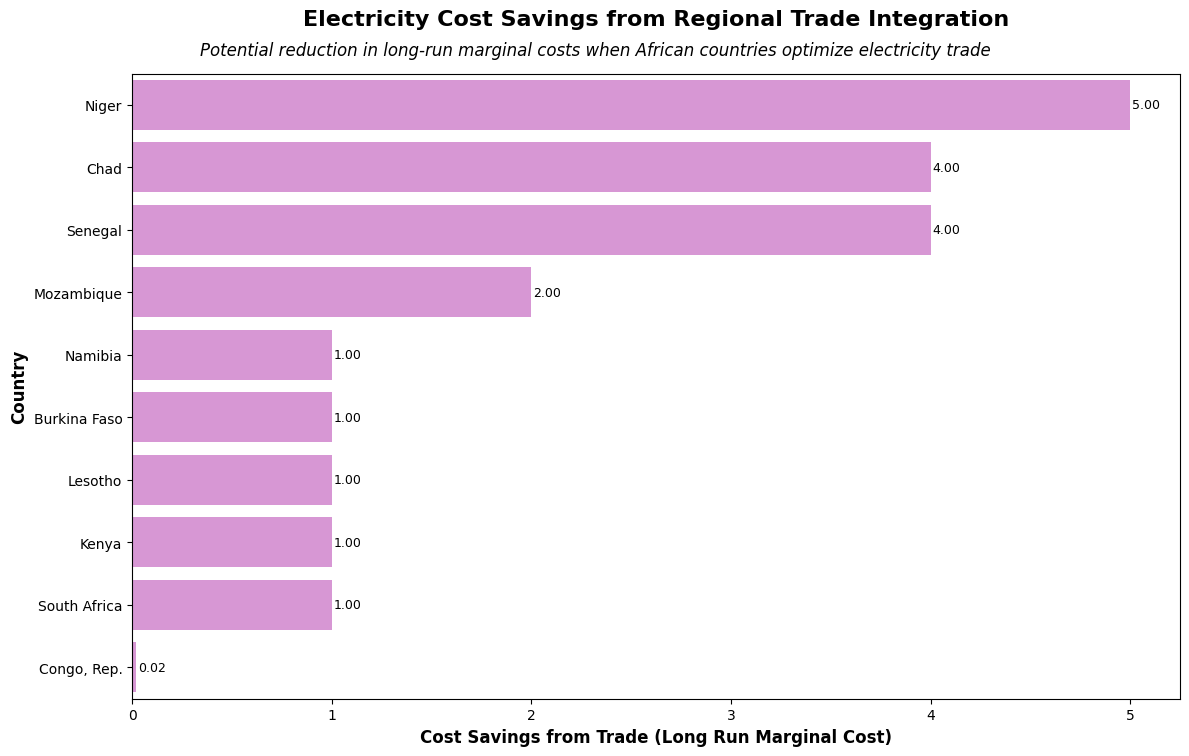

In [6]:
# Simple horizontal bar chart of savings using seaborn
plt.figure(figsize=(12, 8))

# Top 15 countries by savings, sorted highest to lowest
top_countries = df.nlargest(10, "cost_difference")

# Create seaborn barplot with order parameter for highest to lowest
ax = sns.barplot(
    data=top_countries,
    y="country",
    x="cost_difference",
    color="orchid",
    alpha=0.8,
    order=top_countries.sort_values("cost_difference", ascending=False)["country"],
)

plt.xlabel(
    "Cost Savings from Trade (Long Run Marginal Cost)", fontweight="bold", fontsize=12
)
plt.ylabel("Country", fontweight="bold", fontsize=12)
plt.title(
    "Electricity Cost Savings from Regional Trade Integration",
    fontweight="bold",
    fontsize=16,
    pad=35,
)
plt.suptitle(
    "Potential reduction in long-run marginal costs when African countries optimize electricity trade",
    fontsize=12,
    y=0.90,
    style="italic",
)

# Add value labels
for i, value in enumerate(
    top_countries.sort_values("cost_difference", ascending=False)["cost_difference"]
):
    ax.text(value + 0.01, i, f"{value:.2f}", va="center", fontsize=9)

plt.tight_layout()
plt.savefig("figures/africa_lrmc_savings.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Electricity access vs trade benefits analysis
query_2 = """
WITH trade_benefits AS (
    SELECT 
        country,
        (MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, trade stagnation scenario' THEN value END) - 
         MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, optimal trade scenario' THEN value END)) as cost_difference_2005,
        MAX(CASE WHEN indicator = 'Cost of electricity per unit, LRMC, optimal trade scenario' THEN value END) as optimal_trade_cost_2005
    FROM africa_electricity
    WHERE indicator IN (
        'Cost of electricity per unit, LRMC, optimal trade scenario', 
        'Cost of electricity per unit, LRMC, trade stagnation scenario'
    )
    AND year = 2005
    GROUP BY country
    HAVING cost_difference_2005 IS NOT NULL
),
electricity_access AS (
    SELECT 
        country,
        AVG(value) as avg_electricity_access_2010_2020,
        MIN(value) as min_electricity_access_2010_2020,
        MAX(value) as max_electricity_access_2010_2020,
        COUNT(*) as years_of_data
    FROM ida_indicators
    WHERE indicator = 'Access to electricity (% of population)'
      AND year BETWEEN 2010 AND 2020
    GROUP BY country
    HAVING COUNT(*) >= 3  -- At least 3 years of data
)
SELECT 
    tb.country,
    tb.cost_difference_2005,
    tb.optimal_trade_cost_2005,
    ROUND(
        (tb.cost_difference_2005 / tb.optimal_trade_cost_2005) * 100, 2
    ) as percent_cost_savings_from_trade,
    ea.avg_electricity_access_2010_2020,
    ea.min_electricity_access_2010_2020,
    ea.max_electricity_access_2010_2020,
    ea.years_of_data
FROM trade_benefits tb
JOIN electricity_access ea ON tb.country = ea.country
ORDER BY tb.cost_difference_2005 DESC;
"""

# Execute query and load into DataFrame
df = conn.execute(query_2).df()
print(f"Data shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())

Data shape: (22, 8)

First few rows:
      country  cost_difference_2005  optimal_trade_cost_2005  \
0       Niger                   5.0                     25.0   
1     Senegal                   4.0                     43.0   
2        Chad                   4.0                      7.0   
3  Mozambique                   2.0                      4.0   
4     Lesotho                   1.0                      6.0   

   percent_cost_savings_from_trade  avg_electricity_access_2010_2020  \
0                            20.00                         16.113354   
1                             9.30                         61.060000   
2                            57.14                          8.612335   
3                            50.00                         24.276582   
4                            16.67                         30.677709   

   min_electricity_access_2010_2020  max_electricity_access_2010_2020  \
0                         13.395310                         18.774725   

/opt/python/3.7.13/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.



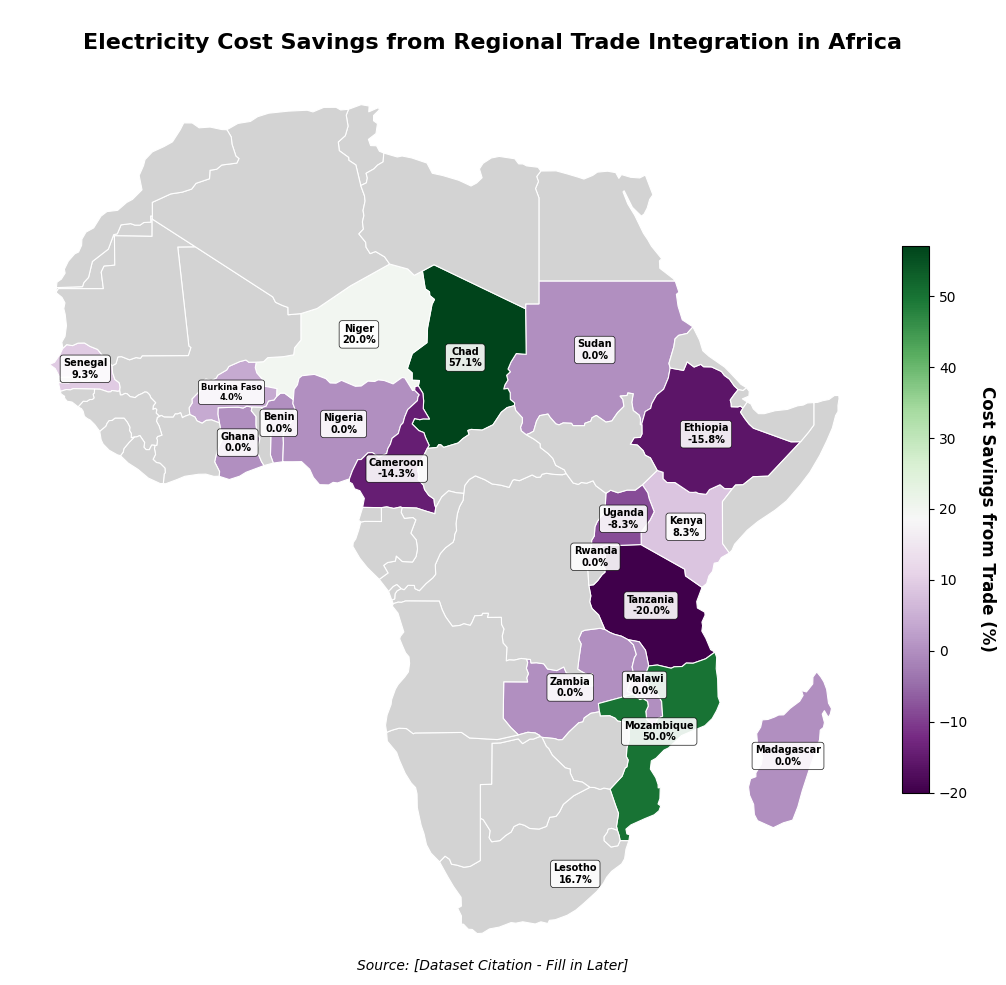

In [58]:
# Load world map data
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
africa = world[world.continent == "Africa"].copy()

# Merge with data from query
africa_data = africa.merge(df, left_on="name", right_on="country", how="left")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.set_position([0.05, 0.1, 0.75, 0.75])

africa_data.plot(
    column="percent_cost_savings_from_trade",
    cmap="PRGn",
    linewidth=0.8,
    ax=ax,
    edgecolor="white",
    legend=False,
    missing_kwds={"color": "lightgray", "edgecolor": "white"},
)

for idx, row in africa_data.iterrows():
    if pd.notna(row.geometry) and pd.notna(row["percent_cost_savings_from_trade"]):
        centroid = row.geometry.centroid
        country_name = row["name"]

        text = f"{country_name}\n{row['percent_cost_savings_from_trade']:.1f}%"
        fontsize = 6 if len(country_name) > 10 else 7

        ax.annotate(
            text,
            xy=(centroid.x, centroid.y),
            ha="center",
            va="center",
            fontsize=fontsize,
            fontweight="bold",
            color="black",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                alpha=0.9,
                edgecolor="black",
                linewidth=0.5,
            ),
        )

fig.suptitle(
    "\nElectricity Cost Savings from Regional Trade Integration in Africa",
    fontsize=16,
    fontweight="bold",
)

fig.text(
    0.5,
    0.02,
    "Source: [Dataset Citation - Fill in Later]",
    ha="center",
    fontsize=10,
    style="italic",
)

ax.set_axis_off()

data_values = africa_data["percent_cost_savings_from_trade"].dropna()
vmin, vmax = data_values.min(), data_values.max()

cmap = cm.get_cmap("PRGn")
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    shrink=0.6,
    pad=0.02,
)

cbar.set_label(
    "Cost Savings from Trade (%)",
    fontsize=12,
    fontweight="bold",
    rotation=270,
    labelpad=20,
)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("africa_trade_map.png", dpi=300, bbox_inches="tight")
plt.show()

/opt/python/3.7.13/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.



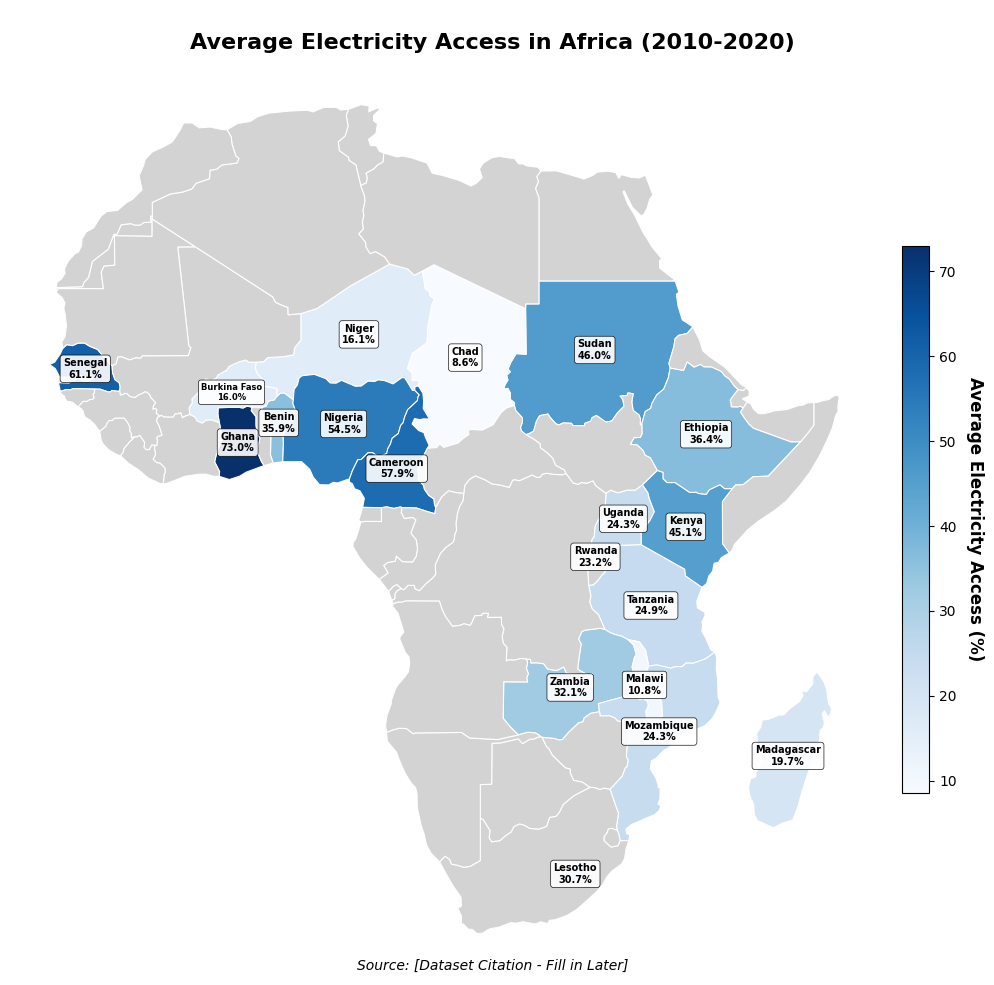

In [ ]:
# Load world map data
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
africa = world[world.continent == "Africa"].copy()

# Merge with data from query
africa_data = africa.merge(df, left_on="name", right_on="country", how="left")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_position([0.05, 0.1, 0.75, 0.75])

column_to_plot = "avg_electricity_access_2010_2020"
colormap = "Blues"

africa_data.plot(
    column=column_to_plot,
    cmap=colormap,
    linewidth=0.8,
    ax=ax,
    edgecolor="white",
    legend=False,
    missing_kwds={"color": "lightgray", "edgecolor": "white"},
)

for idx, row in africa_data.iterrows():
    if pd.notna(row.geometry) and pd.notna(row[column_to_plot]):
        centroid = row.geometry.centroid
        country_name = row["name"]

        text = f"{country_name}\n{row[column_to_plot]:.1f}%"
        fontsize = 6 if len(country_name) > 10 else 7

        ax.annotate(
            text,
            xy=(centroid.x, centroid.y),
            ha="center",
            va="center",
            fontsize=fontsize,
            fontweight="bold",
            color="black",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                alpha=0.9,
                edgecolor="black",
                linewidth=0.5,
            ),
        )

# Update title and labels
fig.suptitle(
    "\nAverage Electricity Access in Africa (2010-2020)",
    fontsize=16,
    fontweight="bold",
)

fig.text(
    0.5,
    0.02,
    "Source: [Dataset Citation - Fill in Later]",
    ha="center",
    fontsize=10,
    style="italic",
)

ax.set_axis_off()

# Colorbar setup
data_values = africa_data[column_to_plot].dropna()
vmin, vmax = data_values.min(), data_values.max()

cmap = cm.get_cmap(colormap)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    shrink=0.6,
    pad=0.02,
)

cbar.set_label(
    "Average Electricity Access (%)",
    fontsize=12,
    fontweight="bold",
    rotation=270,
    labelpad=20,
)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("africa_electricity_access_map.png", dpi=300, bbox_inches="tight")
plt.show()

In [71]:
conn.close()